# Visualizaciones

## Limpieza de datos adicional

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm

# Lectura del dataset
df = pd.read_csv('Netflix.csv')
df.drop(df[df['country'] == 'Unknown'].index, # Eliminar todas las filas que contengan "Unknown" en la cloumna country
        inplace = True)

#Fechas como indice
df['date_added'] = df['date_added'].astype('datetime64[ns]')
df.set_index('date_added', inplace = True)

# Dataframe aparte para hacer un 'explode' a las categorías
df1 = df[df['type']=='Movie']
df1['listed_in'] = df1['listed_in'].str.split(',') # Separo las categorías en listas
listed_exploded = df1.explode('listed_in')
listed_exploded['listed_in'] = listed_exploded['listed_in'].str.strip() # Dataset aparte con las categorías por separado

# Renombrar categorías de distinto nombre y mismo significado
listed_exploded = listed_exploded.replace({'Drama': 'Dramas',
                 'Horror':'Horror Movies', 'Action':'Action & Adventure',
                 'Romance':'Romantic Movies', 'Thriller':'Thrillers',
                 'Sci-fi':'Sci-Fi & Fantasy', })

# Eliminar categoría redundante
listed_exploded.drop(listed_exploded[listed_exploded['listed_in'] == 'Movies'].index, inplace=True) 

# Color map para su uso posterior
colors = ['#FFF5F5', '#FFCCCD', '#FFA3AB', '#FF7A8E', '#C40245']
cmap = LinearSegmentedColormap.from_list('My_cmap', colors, N=5) # Mapa de color personalizado

# En la version 1.0 de GeoPandas no se incluyen los datos de los países para su uso, así que se cargan manualmente
# Carpeta con los archivos necesarios para el mapamundi
world = gpd.read_file('./world/')

# Renombrar columna 'NAME' por 'country', para su posterior uso
world.rename(columns={'NAME':'country'}, inplace=True)

# Selección de las columnas a usar
world = world[['POP_EST','CONTINENT','country', 'ISO_A3', 'GDP_MD', 'geometry']] 

C:\Users\raalv\AppData\Local\Temp\ipykernel_17288\648415867.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['listed_in'] = df1['listed_in'].str.split(',') # Separo las categorías en listas


## Visualizaciones de pandas

#### 1. Películas Vs Series

C:\Users\raalv\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


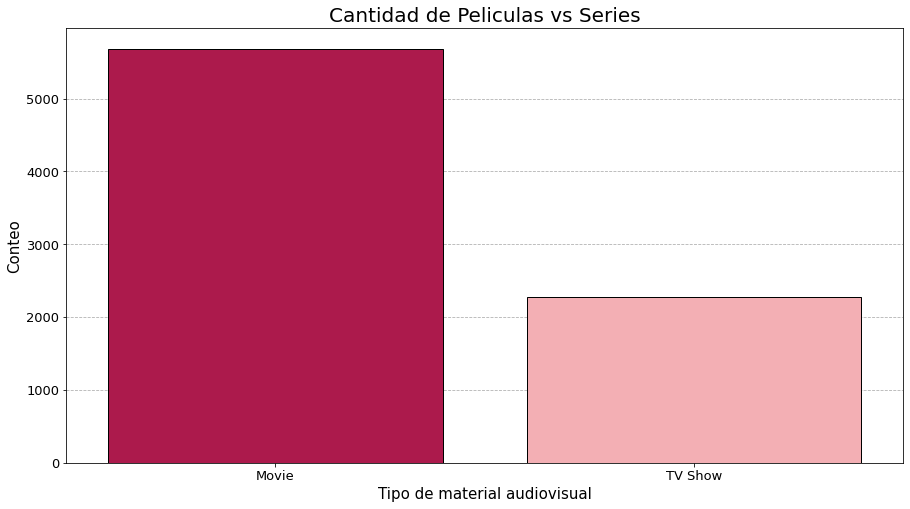

In [2]:
fig, ax = plt.subplots(figsize=(15, 8))
ax = sns.countplot(df['type'], # Gráfico de barras de la cantidad de peliculas vs series
                   palette = ['#C40245', '#FFA3AB'], # Colores de las barras
                   edgecolor='black', # Color del borde de las barras
                   zorder = 2) # Gráfico de barras

ax.grid(linestyle = "--", axis = 'y', zorder = 0) # Cuadrícula punteada que solo párte del eje y
ax.set_title("Cantidad de Peliculas vs Series", fontsize=20) # Título del gráfico

plt.xlabel('Tipo de material audiovisual', fontsize=15) # Nombre de la variable del eje X
plt.ylabel('Conteo', fontsize=15) # Nombre de la variable del eje Y
plt.xticks(rotation = 0, size = 13) # Rotación y tamaño de los valores de la variable del eje X
plt.yticks(size = 13) # Tamaño de los valores de la variable del eje y

plt.savefig('CantPeliculaSerie.jpg', bbox_inches = 'tight') # Guardar imagen
plt.show()

# Seleccionar solo las películas después de haber hecho esta visualización
df = df[df['type']=='Movie']

#### 2. Categorías más subidas a netflix

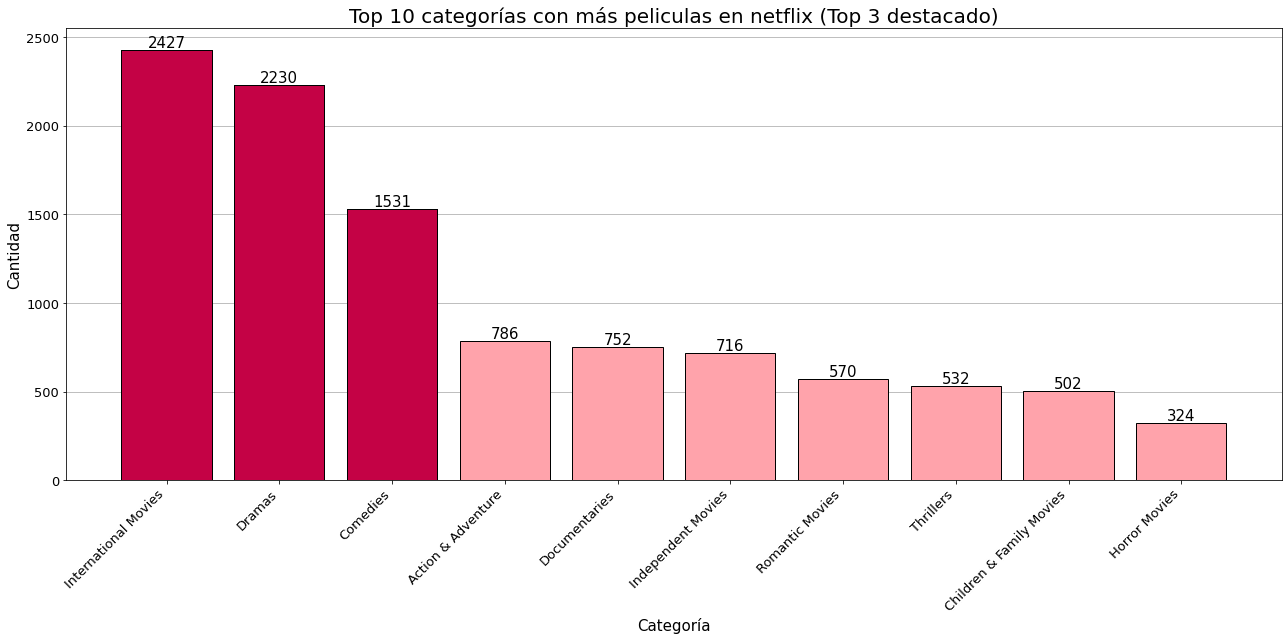

In [3]:
listed_counts = listed_exploded['listed_in'].value_counts().head(10) # Contar las categorías más subidas

# Gráficos de barras
fig, ax = plt.subplots(figsize=(18,9))
ax = plt.bar(listed_counts.index, listed_counts.values, color ='#FFA3AB', edgecolor='black', zorder = 2)

# Agregar los valores encima de las barras
for bar, count in zip(ax, listed_counts.values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.2, count, size=15, ha='center', va='bottom', zorder = 2)

# Cambiar el color al top 3
plt.bar(listed_counts.index[:3], listed_counts.values[:3], color='#C40245', edgecolor='black', zorder = 2)  # Adjust color

# Personalización y detalles
plt.xlabel('Categoría', fontsize = 15)
plt.ylabel('Cantidad', fontsize = 15)
plt.title('Top 10 categorías con más peliculas en netflix (Top 3 destacado)', fontsize=20)
plt.xticks(rotation=45, fontsize = 13, ha='right')
plt.yticks(fontsize = 13)
plt.tight_layout()
plt.grid(axis='y', zorder = 0)
plt.savefig('top_categorías.jpg', bbox_inches = 'tight')

plt.show()

#### 3.1 Heatmap con la cantidad de tipos de película subidas por año (normalizado)

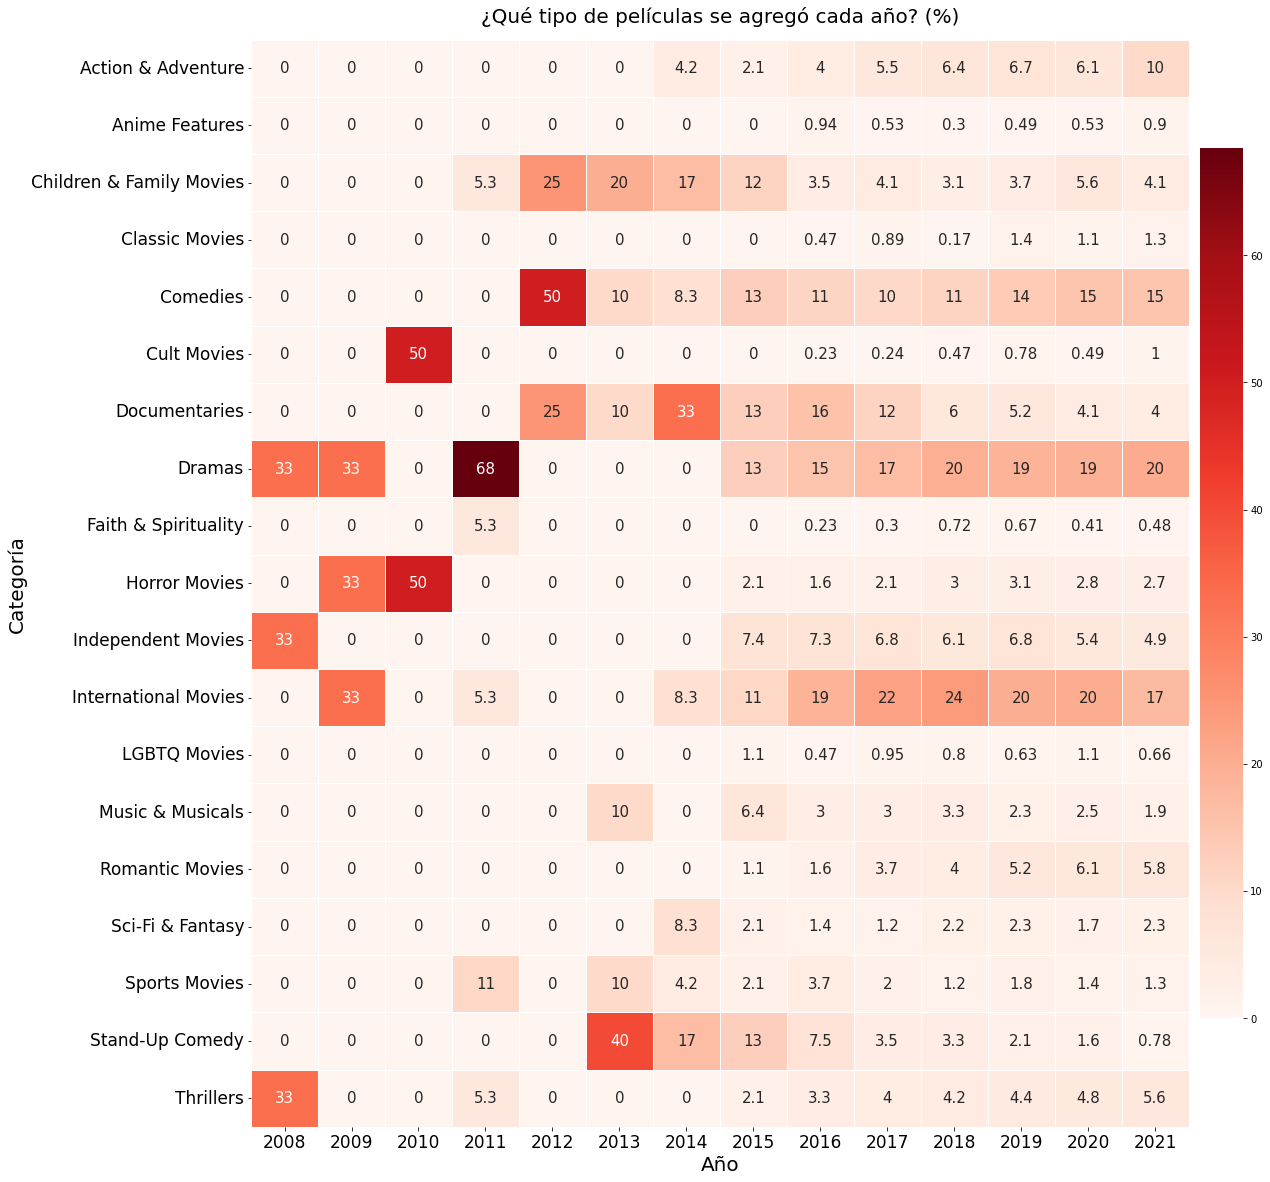

In [4]:
# nuevo dataset con la cantidad de categorías de contenido audiovisual subido por año
new = listed_exploded
new = new.groupby(['listed_in']).resample('y').size().unstack().fillna(0) 

# Normalizando valores a porcetajes
for i in new.columns:
    new[i] = round(new[i]*100/sum(new[i]), 3).fillna(0)

new.columns = new.columns.year

# Mapa de calor con porcentajes
plt.figure(figsize=(20,20))
sns.heatmap(new, 
            cmap='Reds', 
            edgecolor = 'black',
            linewidth=1, 
            cbar_kws=dict(shrink=0.8, pad=0.01), 
            xticklabels=True, annot = True, annot_kws={"fontsize":15})

plt.title('¿Qué tipo de películas se agregó cada año? (%)', y=1.01, fontsize=20)
plt.ylabel('Categoría', fontsize = 20)
plt.xlabel('Año', fontsize = 20)
plt.xticks(size = 17) 
plt.yticks(size = 17) 

plt.savefig('hm_genre_per_year.jpg', bbox_inches = 'tight', dpi=90)
plt.show()

#### 3.2 Entropía de las películas subidas por año.

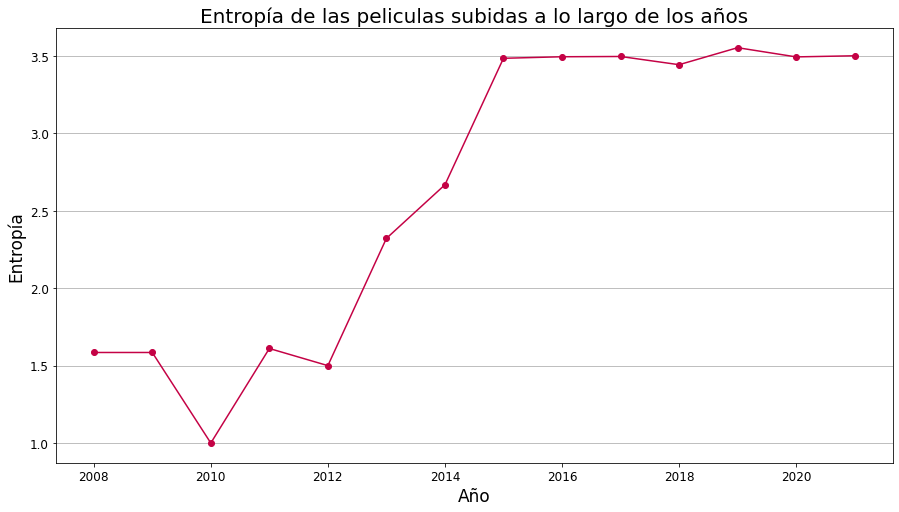

In [5]:
import math as m

entropy = []
for i in new.columns:
    entropia = 0
    for j in new[i]:
        if j > 0:
            entropia -= ((j/100)*m.log2((j/100)))
    entropy.append(entropia)
plt.figure(figsize=(15,8))

plt.title('Entropía de las peliculas subidas a lo largo de los años', fontsize = 20)

plt.xlabel('Año', fontsize=17) 
plt.ylabel('Entropía', fontsize=17) 
plt.xticks(rotation = 0, size = 12) 
plt.yticks(size = 12) 
plt.grid(axis='y')
plt.plot(new.columns, entropy, marker = 'o', color = '#C40245')

plt.savefig('Entropia.jpg', bbox_inches = 'tight')

plt.show(fig)

#### 4. Países que han subido más películas a netflix

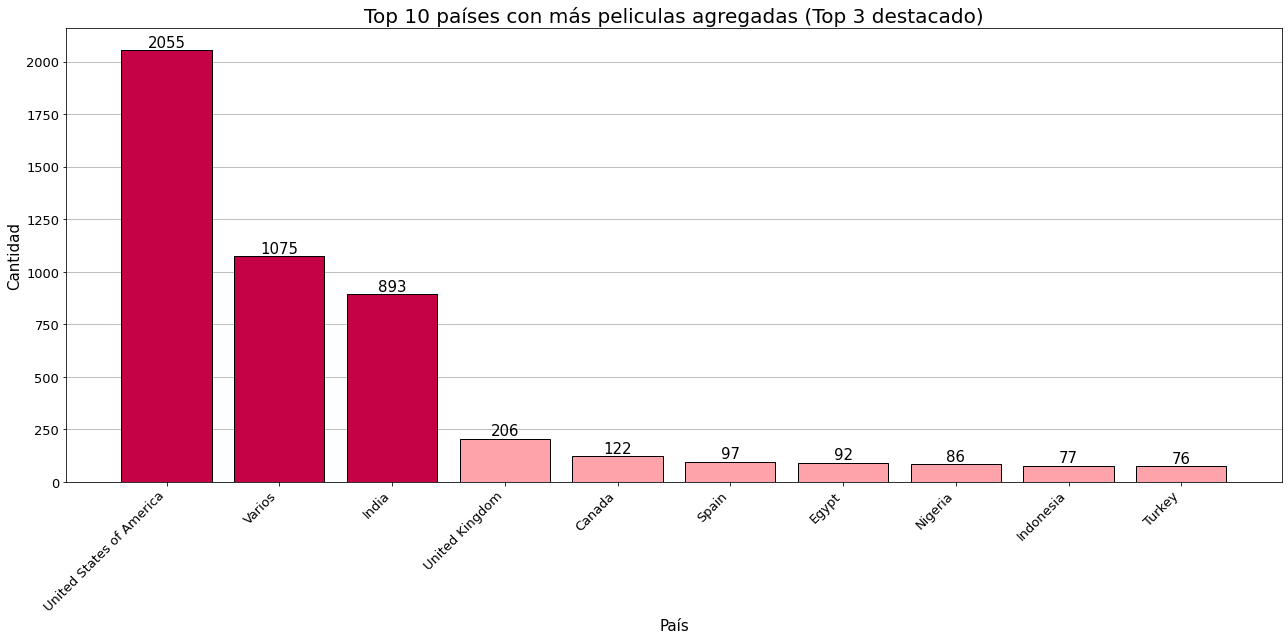

In [6]:

country_counts = df['country'].value_counts().head(10) # Contar las peliculas que ha aportado cada país

fig, ax = plt.subplots(figsize=(18,9))
ax = plt.bar(country_counts.index, country_counts.values, color ='#FFA3AB', edgecolor='black', zorder = 2)


for bar, count in zip(ax, country_counts.values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.2, count, size=15, ha='center', va='bottom', zorder = 2)


plt.bar(country_counts.index[:3], country_counts.values[:3], color='#C40245', edgecolor='black', zorder = 2)  # Adjust color

plt.xlabel('País', fontsize = 15)
plt.ylabel('Cantidad', fontsize = 15)
plt.title('Top 10 países con más peliculas agregadas (Top 3 destacado)', fontsize=20)
plt.xticks(rotation=45, fontsize = 13, ha='right')
plt.yticks(fontsize = 13)
plt.tight_layout()
plt.grid(axis='y', zorder = 0)
plt.savefig('top_paises.jpg', bbox_inches = 'tight')

plt.show()

#### 5.1 Gráfico de líneas del aporte de los 3 países destacados, a través de los años

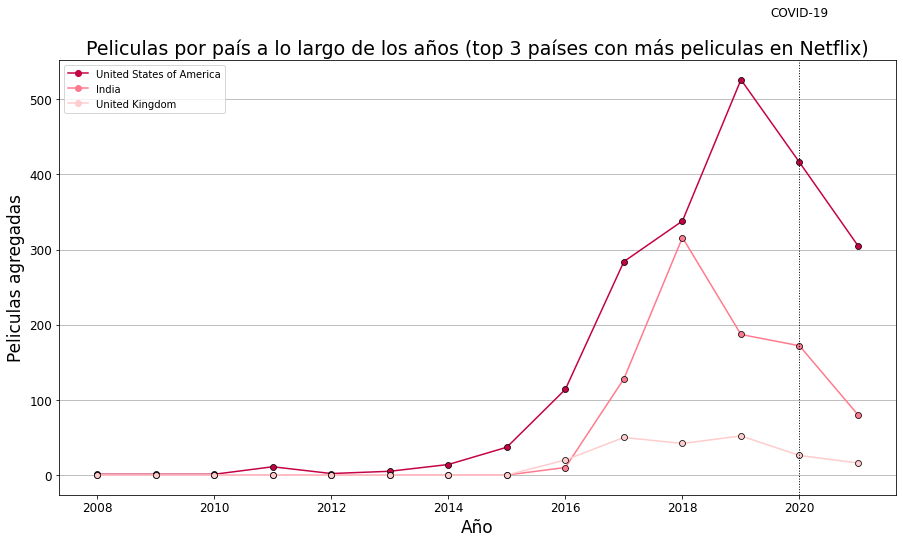

In [7]:
# Dataset con los 3 países que más peliculas han subido a netflix, con un resample por año
other = df
other = other.groupby(['country']).resample('y').size().unstack().fillna(0)
other.columns = other.columns.year
other = other.transpose()
other = other[['United States of America', 'India', 'United Kingdom']]

fig, ax = plt.subplots(figsize=(15, 8)) 
ax = sns.lineplot(data = other, 
                  palette=['#C40245','#FF7A8E', '#FFCCCD'], 
                  dashes = False, # Todas las lineas son continuas
                  markers=['o', 'o', 'o'], # Los marcadores de todos los contribuyentes son del tipo 'o'
                  legend= 'auto', # Leyenda automática
                  markeredgecolor='black') 

ax.grid(axis = 'y')
ax.set_title('Peliculas por país a lo largo de los años (top 3 países con más peliculas en Netflix)', fontsize=19)
ax.axvline(x=2020, color='black', linestyle=':', linewidth=1)
ax.text(2019.5, 
        610, 
        'COVID-19', 
        fontsize = 12) 

ax.legend(loc='upper left')

plt.xlabel('Año', fontsize=17) 
plt.ylabel('Peliculas agregadas', fontsize=17) 
plt.xticks(rotation = 0, size = 12) 
plt.yticks(size = 12) 
plt.savefig('top_paises_storyline.jpg', bbox_inches = 'tight')
plt.show(fig)

#### 5.2 Gráfico de líneas del aporte de los 3 países destacados, acumulado

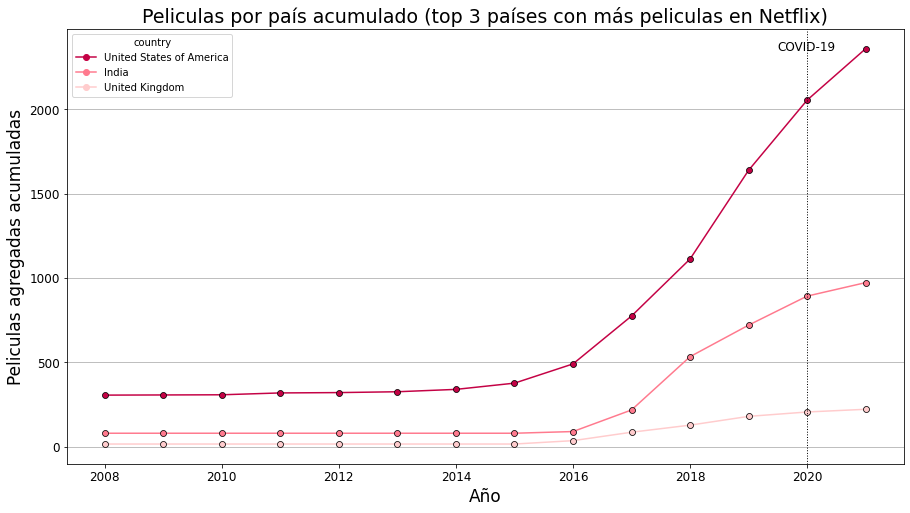

In [8]:
# Dataset con los 3 países que más peliculas han subido a netflix, con un resample por año
other2 = df
other2 = other2.groupby(['country']).resample('y').size().unstack().fillna(0)
other2.columns = other2.columns.year
other2 = other2.transpose()
other2 = other2[['United States of America', 'India', 'United Kingdom']]
for i in range(len(other2.columns)):
    for j in range(len(other2)):
        other2.iloc[j, i] += other2.iloc[j-1, i]
        
fig, ax = plt.subplots(figsize=(15, 8)) 
ax = sns.lineplot(data = other2, 
                  palette=['#C40245','#FF7A8E', '#FFCCCD'], 
                  dashes = False, # Todas las lineas son continuas
                  markers=['o', 'o', 'o'], # Los marcadores de todos los contribuyentes son del tipo 'o'
                  legend= 'auto', # Leyenda automática
                  markeredgecolor='black') 

ax.grid(axis = 'y')
ax.set_title('Peliculas por país acumulado (top 3 países con más peliculas en Netflix)', fontsize=19)
ax.axvline(x=2020, color='black', linestyle=':', linewidth=1)
ax.text(2019.5, 
        2350, 
        'COVID-19', 
        fontsize = 12) 

plt.xlabel('Año', fontsize=17) 
plt.ylabel('Peliculas agregadas acumuladas', fontsize=17) 
plt.xticks(rotation = 0, size = 12) 
plt.yticks(size = 12) 
plt.savefig('top_paises_acumulado_storyline.jpg', bbox_inches = 'tight')
plt.show(fig)

#### 6. Gráfico de palabras según categorías.

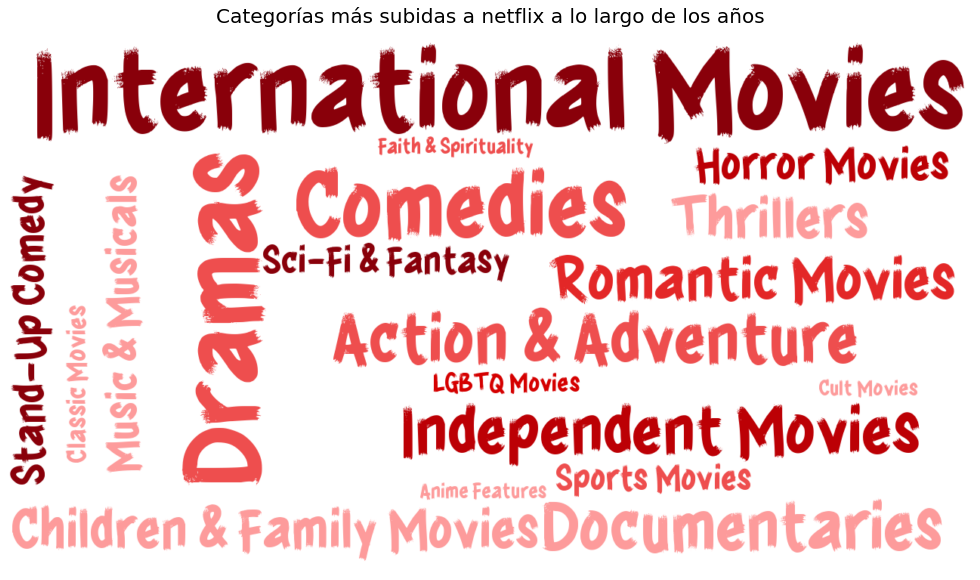

In [37]:
from wordcloud import WordCloud

listed_counts = listed_exploded['listed_in'].value_counts()

colors_2 = ['#89000A', '#BC0005', '#D50000', '#E32727', '#EE4E4E', '#FD9B9B']
cmap_2 = LinearSegmentedColormap.from_list('My_cmap', colors_2, N=6) # Mapa de color personalizado

wordcloud = WordCloud(font_path='gGrest.ttf', width=1280, height=720, background_color='white', colormap=cmap_2).generate_from_frequencies(listed_counts)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Categorías más subidas a netflix a lo largo de los años", fontsize=20)
plt.savefig('NubeDePalabras_CategoríasMasSubidas.jpg')
plt.show()

## Visualizaciones de GeoPandas

#### 1. modificacion de los datos (normalizar y luego categorizar)

In [10]:
listed_ImDC = listed_exploded[(listed_exploded['listed_in'] == 'International Movies') | 
                              (listed_exploded['listed_in'] == 'Dramas') | 
                              (listed_exploded['listed_in'] == 'Comedies')] # Las tres categorías con más contenido audiovisual

# Agrupar por país y por categoría.
grouped = listed_ImDC.groupby(['country', 'listed_in']).size().unstack(fill_value=0)
grouped['country'] = grouped.index
grouped.index.names = ['index']

# Unir el dataset al del mapa mundi
df2 = world.merge(grouped, how='left').fillna(0)

# Columna con porcentajes en vez de numeros enteros
for i in df2.columns[6:]:
    df2[f'{i}_%'] = df2[i]*100/sum(df2[i])

# Rangos de porcentaje para comedias
comedy_bins = [0, 1, 2, 3, 4, 100]
comedy_labels = []
for i in range(len(comedy_bins) - 1):
    start = int(comedy_bins[i])  # Inicio del intervalo
    end = int(comedy_bins[i+1])  # Fin del intervalo
    if start == 4:
        label = f"{start}+"
    else:
        label = f"{start}-{end}"  # Crear la etiqueta como un rango
    comedy_labels.append(label)  # Añadir la etiqueta a la lista

# Categorizar peliculas de comedia
df2['Comedies_CAT'] = pd.cut(df2['Comedies_%'], 
                             bins=comedy_bins, 
                             labels=comedy_labels, 
                             include_lowest=True)

# Rangos de porcentaje para las otras dos categorías
bins = [0, 1.5, 3, 4.5, 6, 100]
labels = []
for i in range(len(bins) - 1):
    start = float(bins[i])  # Inicio del intervalo
    end = float(bins[i+1])  # Fin del intervalo
    if start == 6:
        label = f"{start}+"
    else:
        label = f"{start}-{end}"  # Crear la etiqueta como un rango
    labels.append(label)  # Añadir la etiqueta a la lista

# Categorizar las peliculas de drama
df2['Dramas_CAT'] = pd.cut(df2['Dramas_%'], 
                             bins=bins, 
                             labels=labels, 
                             include_lowest=True)

# Categorizar las peliculas internacionales.
df2['International Movies_CAT'] = pd.cut(df2['International Movies_%'], 
                             bins=bins, 
                             labels=labels, 
                             include_lowest=True)


#### 2. Coropletas de las películas internacionales

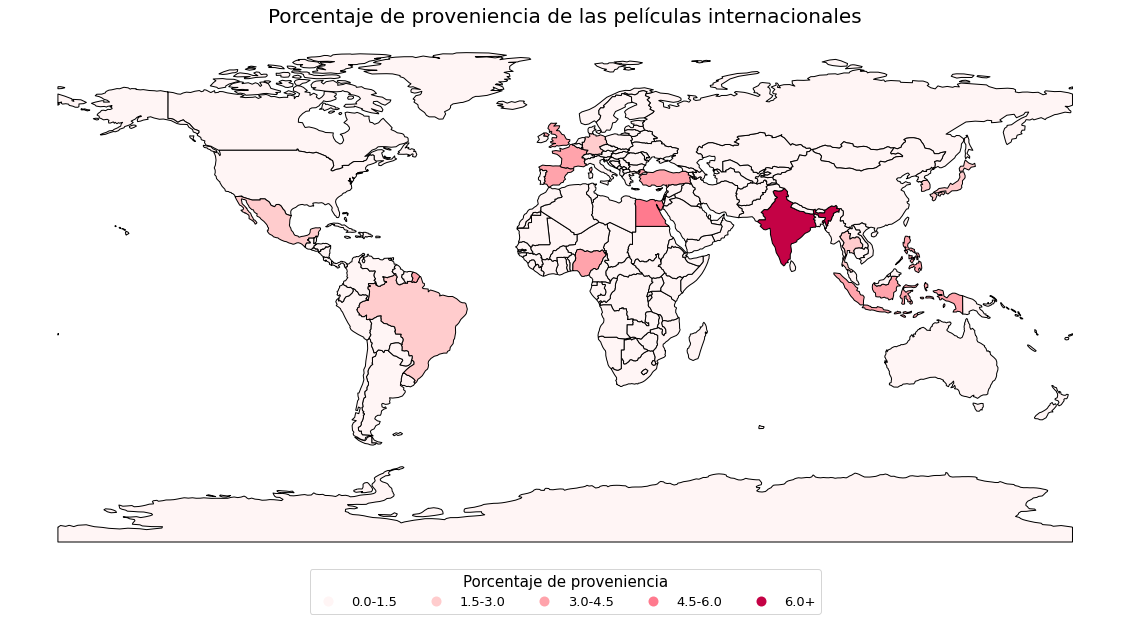

In [11]:
fig, ax = plt.subplots(figsize=(20, 20))

# Mapamundi pintando los países de donde provengan más peliculas internacionales
df2.plot(column='International Movies_CAT', 
         ax=ax, 
         legend=True, 
         cmap = cmap, 
         edgecolor='black', legend_kwds={'title': "Porcentaje de proveniencia", 
                                         'loc': 'lower center', 'bbox_to_anchor': (0.5, -0.1),
                                         'ncol':5,
                                         'title_fontsize': '15', 
                                         'fontsize': '13'})

ax.set_title('Porcentaje de proveniencia de las películas internacionales', fontsize = 20)
ax.set_axis_off()

plt.savefig('Proveniencia_peliculas_internacionales.jpg', bbox_inches = 'tight')

plt.show()

#### 3. Coropletas de las películas de drama

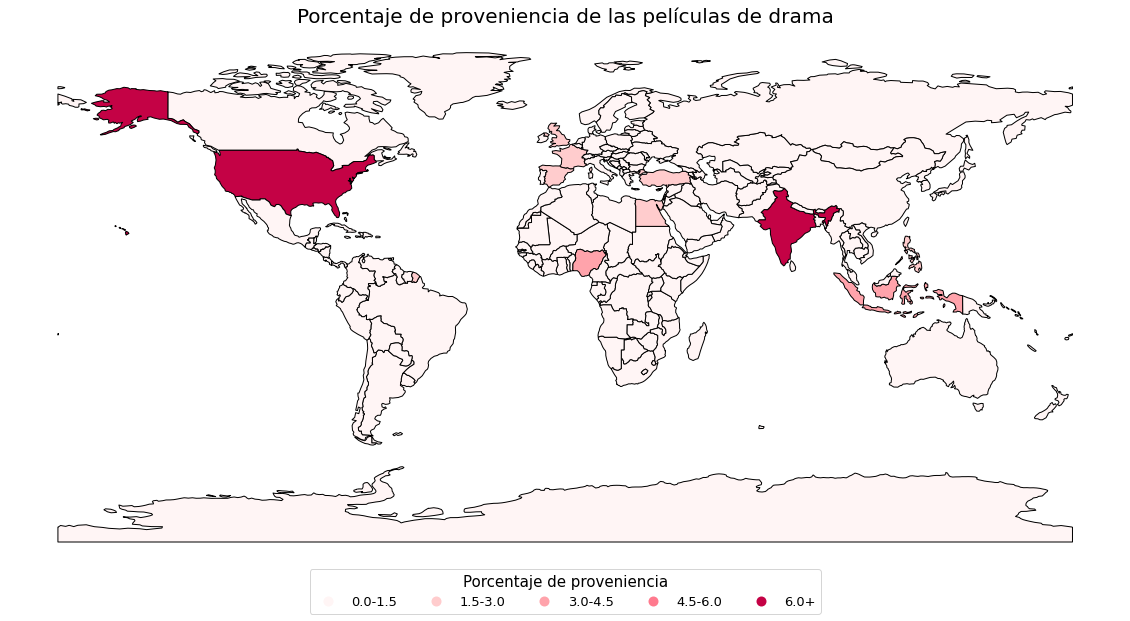

In [12]:
# Mapamundi pintando los países de donde provengan más peliculas de drama
fig, ax = plt.subplots(figsize=(20, 20))
df2.plot(column='Dramas_CAT', 
         ax=ax, 
         legend=True, 
         cmap = cmap, 
         edgecolor='black', legend_kwds={'title': "Porcentaje de proveniencia", 
                                         'loc': 'lower center', 'bbox_to_anchor': (0.5, -0.1),
                                         'ncol':5,
                                         'title_fontsize': '15', 
                                         'fontsize': '13'})
ax.set_title('Porcentaje de proveniencia de las películas de drama', fontsize = 20)
ax.set_axis_off()

plt.savefig('Proveniencia_peliculas_drama.jpg', bbox_inches = 'tight')

plt.show()

#### 4. Coropletas de las películas de comedia

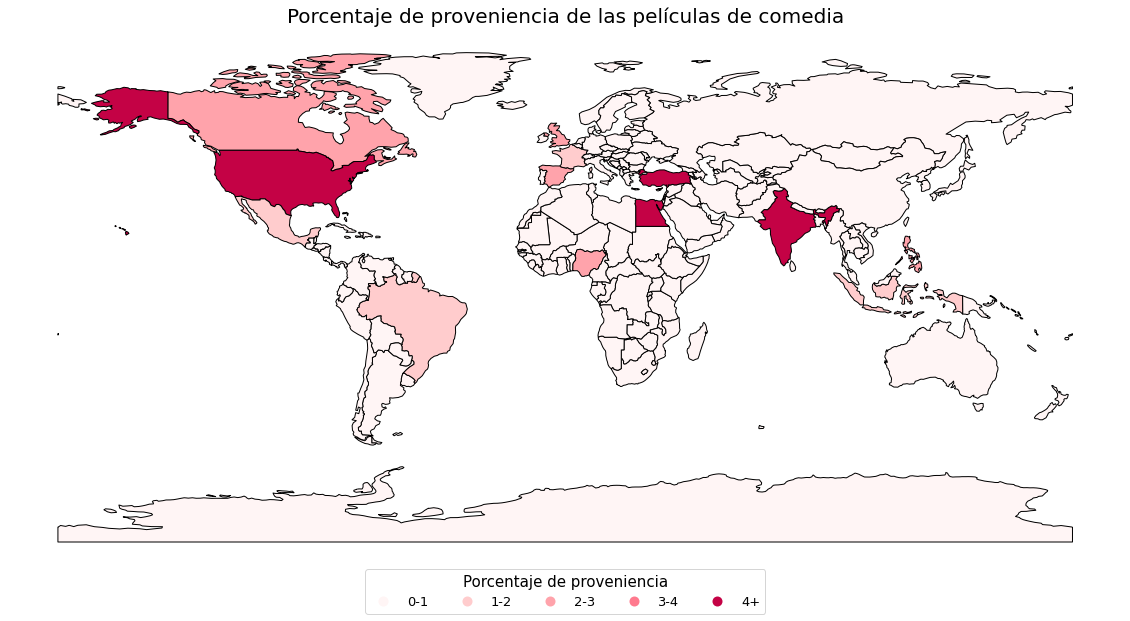

In [13]:
# Mapamundi pintando los países de donde provengan más peliculas de comedia
fig, ax = plt.subplots(figsize=(20, 20))
df2.plot(column='Comedies_CAT', 
         ax=ax, 
         legend=True, 
         cmap = cmap, 
         edgecolor='black', legend_kwds={'title': "Porcentaje de proveniencia", 
                                         'loc': 'lower center', 'bbox_to_anchor': (0.5, -0.1),
                                         'ncol':5,
                                         'title_fontsize': '15', 
                                         'fontsize': '13'})
ax.set_title('Porcentaje de proveniencia de las películas de comedia', fontsize = 20)
ax.set_axis_off()

plt.savefig('Proveniencia_peliculas_comedia.jpg', bbox_inches = 'tight')

plt.show()